In [1]:
import os
from os.path import join
from astropy.io import fits
import numpy as np
from maskmoment import maskmoment
from dendroplot import run_dendro
from dendroplot.analysis import calc_phys_props, find_clusters
from dendroplot.plotting import colorcode, pltprops
from dendroplot.lte import lte, add_ltemass
import warnings
warnings.filterwarnings('ignore')
%load_ext autotime

time: 112 µs (started: 2022-07-10 11:55:27 -07:00)


# Example for 30 Doradus Cycle 0 data from [Indebetouw et al. (2013)](https://doi.org/10.1088/0004-637X/774/1/73)

In [2]:
# Directory where input images reside.
indir = os.getcwd()

# Directories to write output files.
momdir = join(indir, 'mom')
if not os.path.isdir(momdir):
    os.makedirs(momdir)
    
ltedir = join(indir, 'lte')
if not os.path.isdir(ltedir):
    os.makedirs(ltedir)

dendir = join(indir, 'dendro')
if not os.path.isdir(dendir):
    os.makedirs(dendir)

time: 630 µs (started: 2022-07-10 11:55:27 -07:00)


## Generate moment maps from cubes via dilated masking
This is done using the external `maskmoment` package (https://github.com/tonywong94/maskmoment).

In [3]:
dolines = ['12', '13']

for line in dolines:
    maskmoment(img_fits=join(indir,'30dor_'+line+'CO21_2p5as.pbcor.fits.gz'), 
        rms_fits=join(indir,'30dor_'+line+'CO21_2p5as.rms.fits.gz'), outdir=momdir,
        snr_hi=4, snr_lo=2, minbeam=2, snr_hi_minch=2, nguard=[1,1], 
        outname='30dor_'+line+'CO21_2p5as_dil', output_snr_peak=True)


Output basename is: 30dor_12CO21_2p5as_dil
Image cube /Users/tonywong/Work/bin/py-package/dendroplot/example/30dor_12CO21_2p5as.pbcor.fits.gz:
 SpectralCube with shape=(120, 500, 500) and unit=K:
 n_x:    500  type_x: RA---SIN  unit_x: deg    range:    84.637472 deg:   84.754024 deg
 n_y:    500  type_y: DEC--SIN  unit_y: deg    range:   -69.097414 deg:  -69.055831 deg
 n_s:    120  type_s: VRAD      unit_s: m / s  range:   220155.466 m / s:  279696.656 m / s
Noise cube /Users/tonywong/Work/bin/py-package/dendroplot/example/30dor_12CO21_2p5as.rms.fits.gz:
 SpectralCube with shape=(120, 500, 500) and unit=K:
 n_x:    500  type_x: RA---SIN  unit_x: deg    range:    84.637472 deg:   84.754024 deg
 n_y:    500  type_y: DEC--SIN  unit_y: deg    range:   -69.097414 deg:  -69.055831 deg
 n_s:    120  type_s: VRAD      unit_s: m / s  range:   220155.466 m / s:  279696.656 m / s
SNR cube:
 SpectralCube with shape=(120, 500, 500):
 n_x:    500  type_x: RA---SIN  unit_x: deg    range:    84.6374

## Compute the LTE column density

In [4]:
tmin = 6  # Floor on Tex of 6 K

incube12 = join(indir, '30dor_12CO21_2p5as.pbcor.fits.gz')
incube13 = join(indir, '30dor_13CO21_2p5as.pbcor.fits.gz')
inrms12  = join(indir, '30dor_12CO21_2p5as.rms.fits.gz')
inrms13  = join(indir, '30dor_13CO21_2p5as.rms.fits.gz')
inmask12 = join(momdir,'30dor_12CO21_2p5as_dil.mask.fits.gz')
lte_names = [incube12, incube13, inrms12, inrms13, inmask12]

lte(files=lte_names, tfloor=tmin, outdir=ltedir, outname='30dor_2p5', tx_method='peak')


Reading /Users/tonywong/Work/bin/py-package/dendroplot/example/30dor_12CO21_2p5as.pbcor.fits.gz...
The 12CO rest frequency is 230.5380 GHz
min/max values of 12CO [K] are -3.50 and 51.48

Reading /Users/tonywong/Work/bin/py-package/dendroplot/example/30dor_12CO21_2p5as.rms.fits.gz...
min/max values of 12CO uncertainty are 0.112 and 0.561

Reading /Users/tonywong/Work/bin/py-package/dendroplot/example/mom/30dor_12CO21_2p5as_dil.mask.fits.gz...
Number of mask == 1 values: 1288518
Number of mask == 0 values: 28711482
Number of mask == NaN values: 0

Calculating Tex [excitation temperature]...
min/max values of Tex [K] are 6.00 K and 57.03 K
File /Users/tonywong/Work/bin/py-package/dendroplot/example/lte/30dor_2p5_peak_tex12.fits.gz successfully written

Reading /Users/tonywong/Work/bin/py-package/dendroplot/example/30dor_13CO21_2p5as.pbcor.fits.gz...
The 13CO rest frequency is 220.3987 GHz
min/max values of 13CO [K] are -1.64 and 19.58

Reading /Users/tonywong/Work/bin/py-package/dendropl

## Run the dendrogram analysis and calculate physical properties
Although typically we use the `volume` criterion in SCIMES, this yields only a few clumps for this dataset, so we apply a `radius` criterion instead.


Robustly estimated RMS: 0.109
Pixels per beam: 78.68
Loading pre-existing dendrogram
Generate a catalog of dendrogram structures
<Table length=166>
     name       dtype    unit 
-------------- ------- -------
          _idx   int64        
  area_ellipse float64 arcsec2
    area_exact float64 arcsec2
          flux float64      Jy
   major_sigma float64  arcsec
   minor_sigma float64  arcsec
position_angle float64     deg
        radius float64  arcsec
         v_cen float64     pix
         v_rms float64   m / s
         x_cen float64     pix
         y_cen float64     pix

Image the trunks
Finding descendants of trunk 1
Finding descendants of trunk 106
Image the leaves
- Creating affinity matrices
- Start spectral clustering
-- Rescaling radius matrix
-- Estimated scaling parameter: 4.181285
-- Guessed number of clusters = 10
-- Number of k-means iteration: 1
-- Best cluster number found through SILHOUETTE (0.924902)= 3
SAVE_BRANCHES triggered, all isolated branches will be retaine

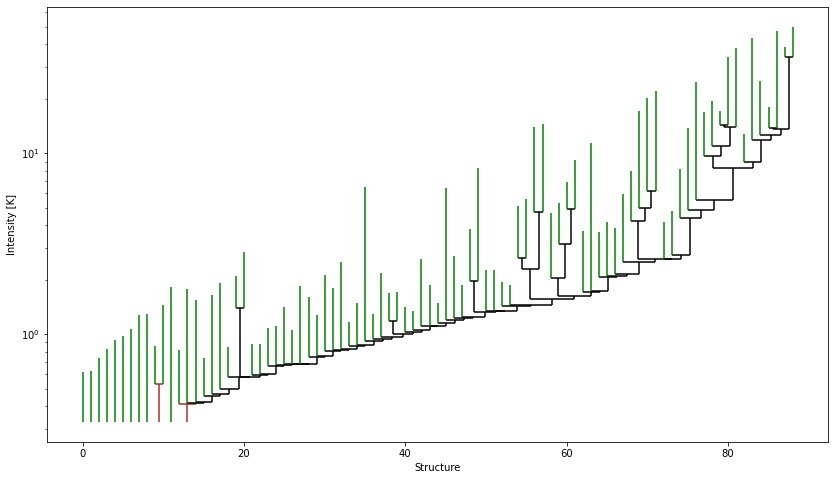

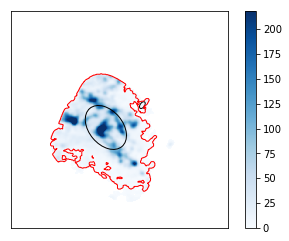

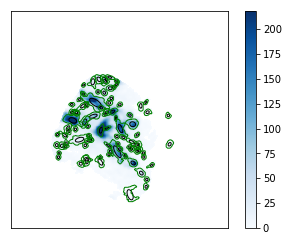

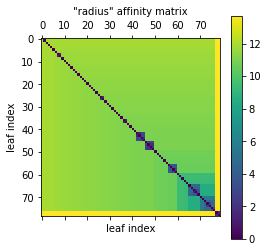

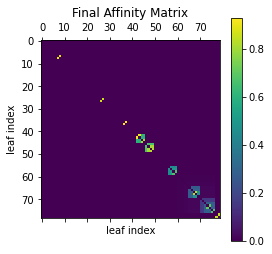

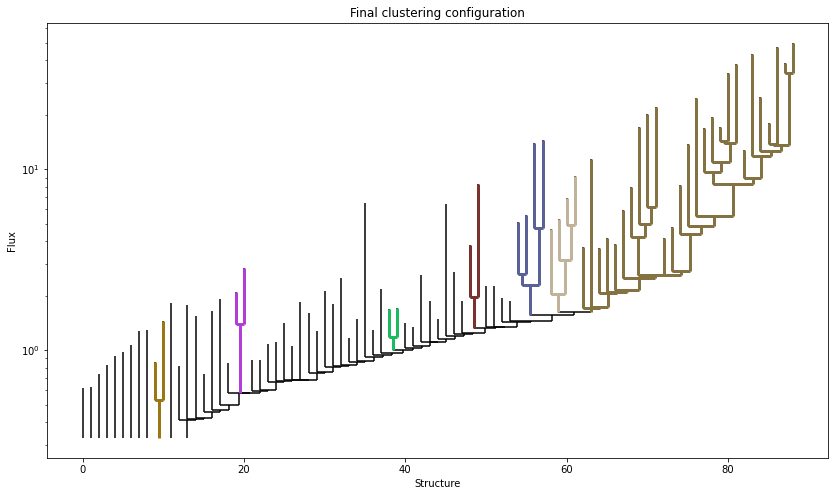

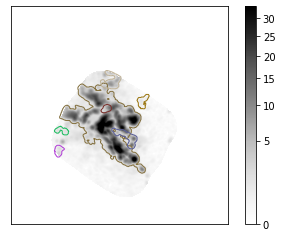

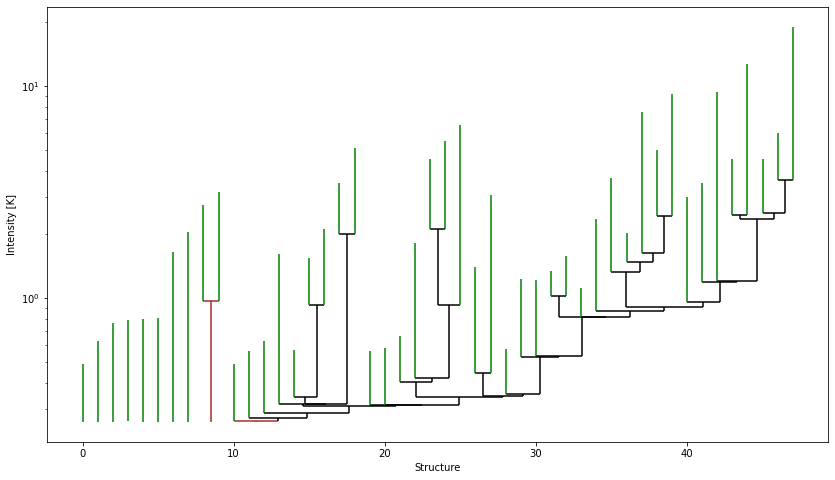

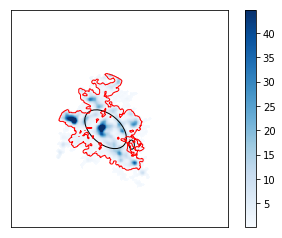

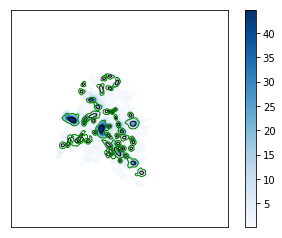

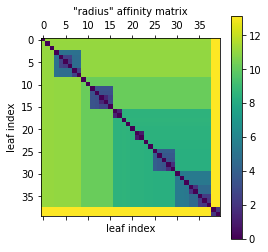

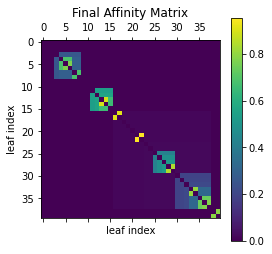

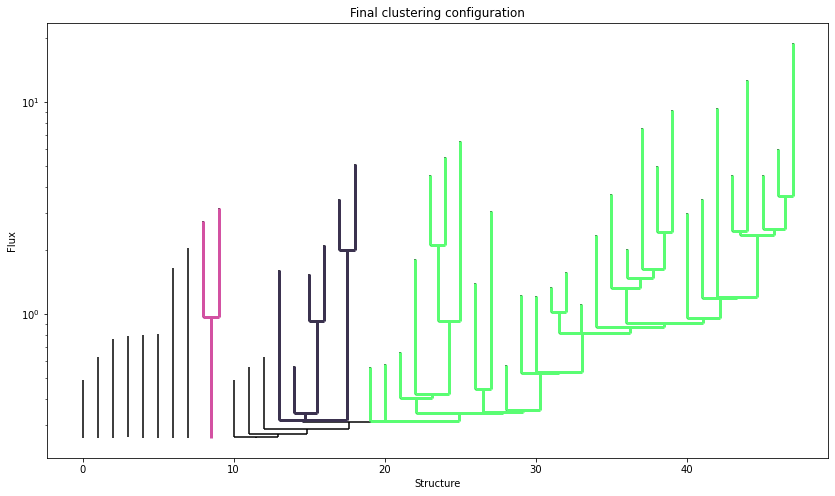

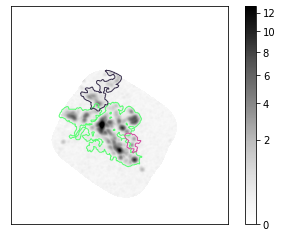

time: 6min 34s (started: 2022-07-10 11:55:49 -07:00)


In [5]:
redo = 'n'              # whether to regenerate dendrogram.hdf file
alphascale = 3          # scaling factor for XCO
#criteria = ['volume']
criteria = ['radius']   # SCIMES criteria

old_dir = os.getcwd()
os.chdir(dendir)

pbcor = [join(indir, '30dor_12CO21_2p5as.pbcor.fits.gz')]
pbcor.append(join(indir, '30dor_13CO21_2p5as.pbcor.fits.gz'))
rmsfile = [join(indir, '30dor_12CO21_2p5as.rms.fits.gz')]
rmsfile.append(join(indir, '30dor_13CO21_2p5as.rms.fits.gz'))

for i, line in enumerate(['12', '13']):
    label = '30dor_'+line
    flatfile = join(indir, '30dor_'+line+'CO21_2p5as.image.fits.gz')
    # Produce a noise-flat cube for signal identification
    if not os.path.isfile(flatfile):
        cubearray, hdr = fits.getdata(pbcor[i], header=True)
        rmsarray = fits.getdata(rmsfile[i])
        rms_min = np.nanmin(rmsarray)
        print('Min value of',rmsfile,'is',rms_min)
        gainarray = rms_min/rmsarray
        flatarray = cubearray * np.broadcast_to(gainarray, cubearray.shape)
        fits.writeto(flatfile, flatarray.astype(np.float32), hdr, overwrite=True)
    mom0file = join(momdir, '30dor_'+line+'CO21_2p5as_dil.mom0.fits.gz')

    run_dendro(label=label, cubefile=flatfile, mom0file=mom0file, 
               redo=redo, verbose=False)
    find_clusters(criteria=criteria, label=label, cubefile=flatfile)
    calc_phys_props(label=label, cubefile=flatfile, efloor=0.05,
        alphascale=alphascale, copbcor=pbcor[0], conoise=rmsfile[0])
    if os.path.isfile(join(ltedir, '30dor_2p5_peak_n13cube.fits.gz')):
        add_ltemass(n13cub=join(ltedir, '30dor_2p5_peak_n13cube.fits.gz'), 
            i12cub=pbcor[0], i13cub=pbcor[1], co13toh2=3.0e6, label=label,
            n13cub_uc=join(ltedir, '30dor_2p5_peak_n13cubeerr.fits.gz'))

os.chdir(old_dir)

## Color the dendros by mean velocity and velocity dispersion


Opening 30dor_12_full_catalog.txt

Working on leaves
Image leaves and clusters colored by properties

Working on v_cen
v0, v1: 220.30505081268805 272.0909747135351
Ticks: ['240', '260']
v_cen vmin and vmax: 220.30505081268805 272.0909747135351

Working on v_rms
v0, v1: 0.24870134164080418 3.1971529745276497
Ticks: ['1', '2', '3']
v_rms vmin and vmax: 0.24870134164080418 3.1971529745276497
Working on trunks
Image leaves and clusters colored by properties

Working on v_cen
v0, v1: 248.75253628946336 249.83665958011005
Ticks: ['249']
v_cen vmin and vmax: 248.75253628946336 249.83665958011005

Working on v_rms
v0, v1: 0.8491182799275424 4.836609474534936
Ticks: ['1', '2', '3', '4']
v_rms vmin and vmax: 0.8491182799275424 4.836609474534936
Working on clusters
Image leaves and clusters colored by properties

Working on v_cen
v0, v1: 242.10794202589128 260.32389131982933
Ticks: ['250', '260']
v_cen vmin and vmax: 242.10794202589128 260.32389131982933

Working on v_rms
v0, v1: 0.8491182799275

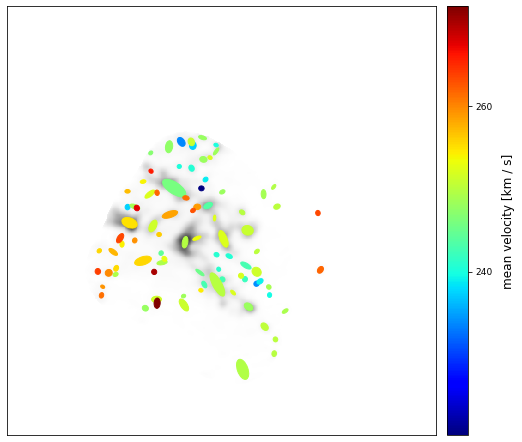

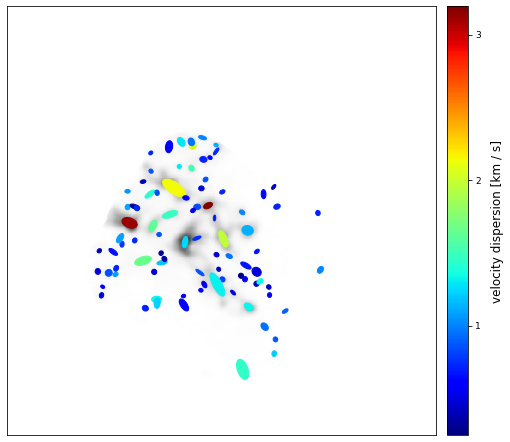

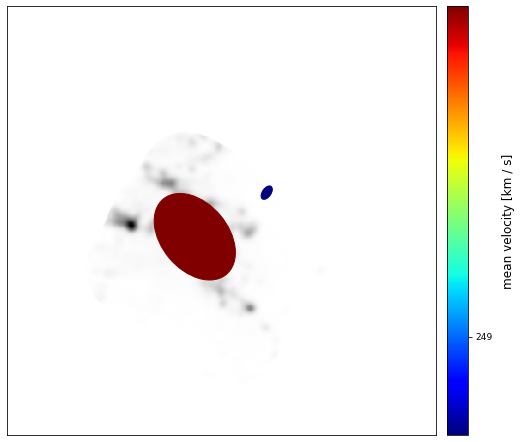

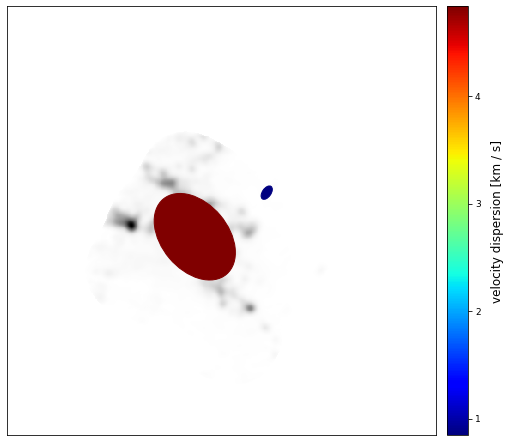

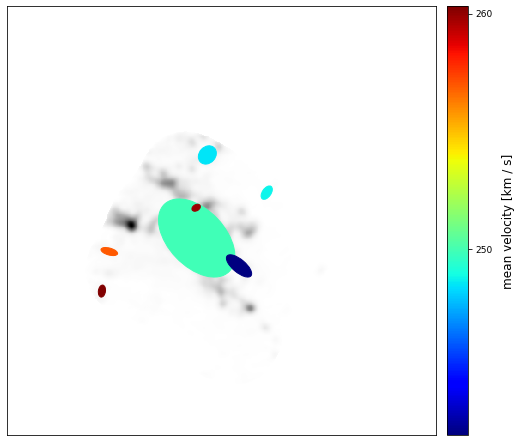

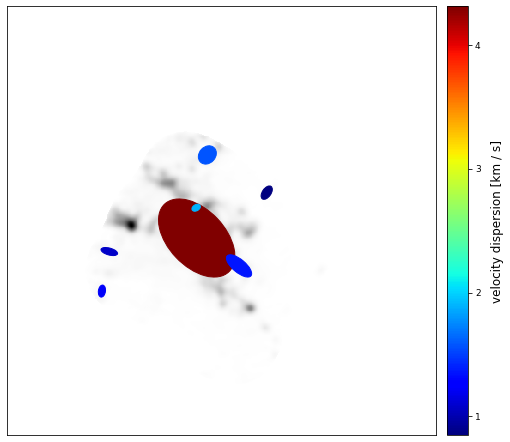

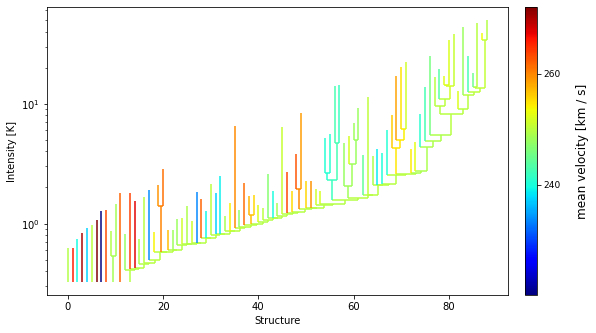

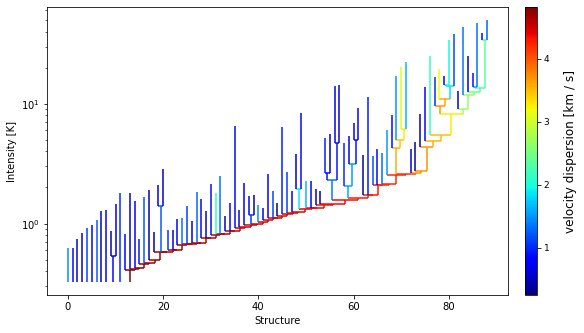

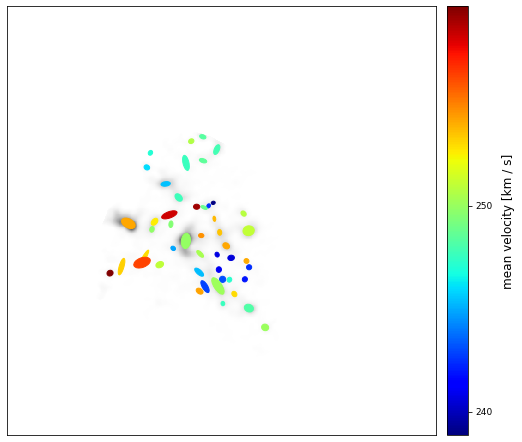

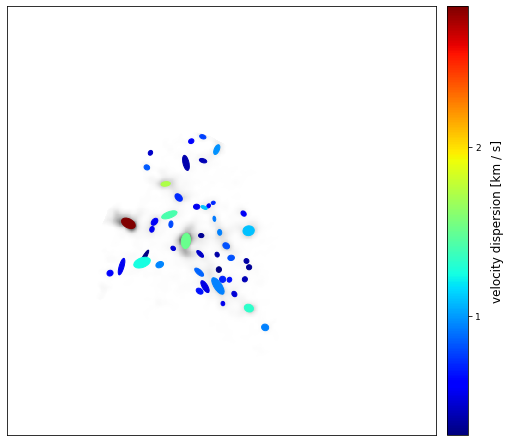

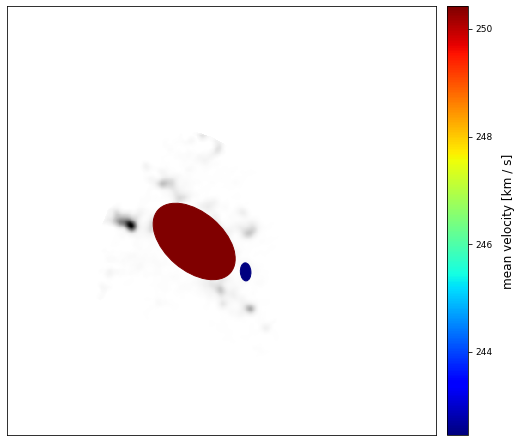

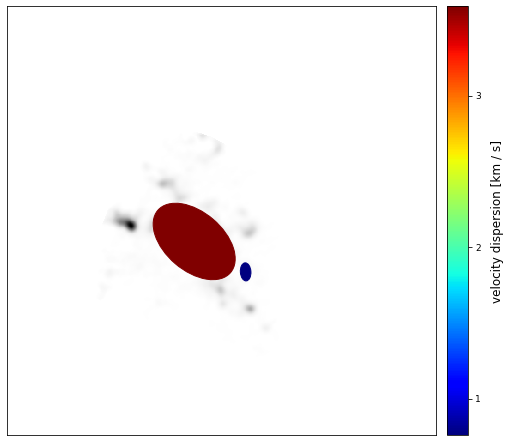

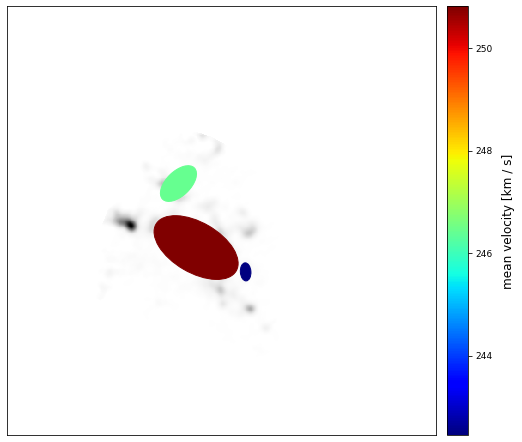

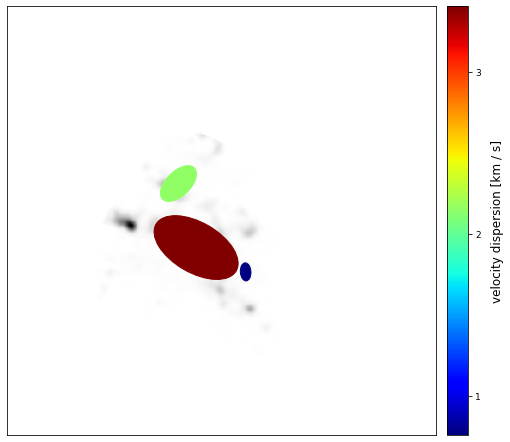

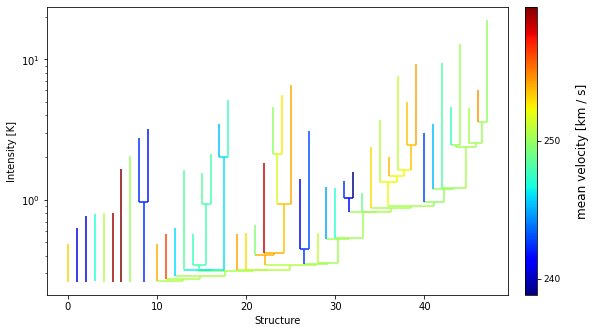

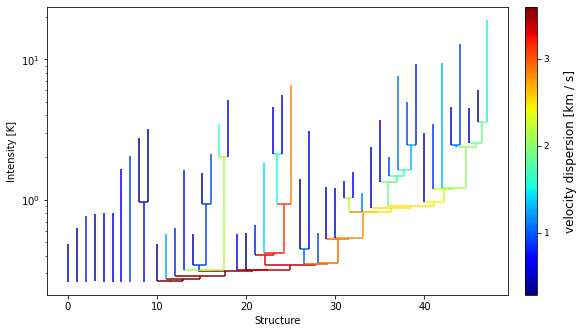

time: 9.92 s (started: 2022-07-10 12:02:23 -07:00)


In [6]:
old_dir = os.getcwd()
os.chdir(dendir)

for i, line in enumerate(['12', '13']):
    label = '30dor_'+line
    flatfile = join(indir, '30dor_'+line+'CO21_2p5as.image.fits.gz')
    mom0file = join(momdir, '30dor_'+line+'CO21_2p5as_dil.mom0.fits.gz')
    colorcode(label=label, cubefile=flatfile, mom0file=mom0file, types=['v_cen','v_rms'])

os.chdir(old_dir)

## Plot the cloud property correlations


*** Plotting rad_pc_dcon and vrms_k
81 points selected for display
Excluding points from vrms_k below 0.21233045007200477

Lineregress parameters: 0.27 + x*(0.52+/-0.03)

======== Results kmpfit with effective variance =========
Fitted parameters:       [0.30113194626619066, 0.48885531641885044]
Covariance errors:       [0.00927053 0.01415791]
Standard errors:         [0.01969166 0.030073  ]
Chi^2 min:               356.436638241029
Reduced Chi^2:           4.51185618026619
Status Message: mpfit (potential) success: Convergence in chi-square value (1)

======== Results from scipy.odr =========
Beta: [0.30113422 0.48885165]
Beta Std Error: [0.01969158 0.03007288]
Beta Covariance: [[ 8.59421007e-05 -1.24180437e-04]
 [-1.24180437e-04  2.00444744e-04]]
Residual Variance: 4.511856181235144
Inverse Condition #: 0.1455483809337697
Reason(s) for Halting:
  Sum of squares convergence
Plotting 2 trunk(s)
Plotting 78 trunk descendants
Plotting 4 cluster(s)

Lineregress parameters: 0.11 + x*(0.74

Relation will be color coded by alpha
Percentile 25 for alpha has value 0.11232002602540234
Percentile 75 for alpha has value 0.13110453514075604
Upper quartile fit: 1.59 + x*(0.50+/-0.09)
dnarrow: [0.11232003 0.29420678]
uparrow: [0.13110454 0.30351047]

*** Plotting rad_pc_dcon and vrms_k
40 points selected for display
Excluding points from vrms_k below 0.21233045007200477

Lineregress parameters: 0.23 + x*(0.41+/-0.06)

======== Results kmpfit with effective variance =========
Fitted parameters:       [0.2573628312508197, 0.37496450347347154]
Covariance errors:       [0.00860659 0.01696389]
Standard errors:         [0.02939079 0.05793027]
Chi^2 min:               443.14273793487587
Reduced Chi^2:           11.661650998286207
Status Message: mpfit (potential) success: Convergence in chi-square value (1)

======== Results from scipy.odr =========
Beta: [0.25736758 0.37495354]
Beta Std Error: [0.02939047 0.05792955]
Beta Covariance: [[ 7.40718299e-05 -1.24632863e-04]
 [-1.24632863e-04 

Plotting 3 cluster(s)

Lineregress parameters: 0.09 + x*(1.14+/-0.23)

======== Results kmpfit with effective variance =========
Fitted parameters:       [0.5579394830174453, 0.9440390724744551]
Covariance errors:       [0.33937233 0.13907898]
Standard errors:         [0.93645674 0.38377157]
Chi^2 min:               7.614170024347054
Reduced Chi^2:           7.614170024347054
Status Message: mpfit (potential) success: Convergence in chi-square value (1)

======== Results from scipy.odr =========
Beta: [0.55793938 0.94403912]
Beta Std Error: [0.93645705 0.38377176]
Beta Covariance: [[ 0.11517366 -0.04704334]
 [-0.04704334  0.01934298]]
Residual Variance: 7.614170024347167
Inverse Condition #: 0.002662442585839216
Reason(s) for Halting:
  Sum of squares convergence
Relation will be color coded by alpha
Percentile 25 for alpha has value -0.14398417455291382
Percentile 75 for alpha has value 0.04989789573778245
Upper quartile fit: 1.21 + x*(0.68+/-0.22)
dnarrow: [-0.14398417  0.29317939]
u

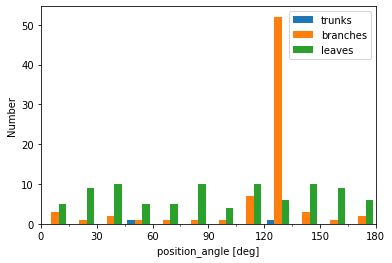

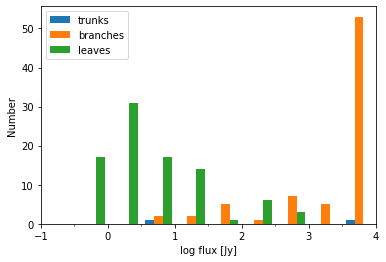

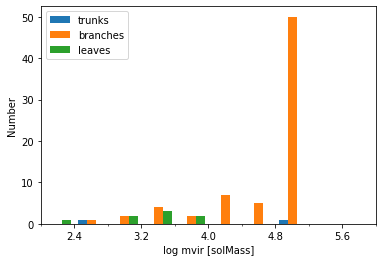

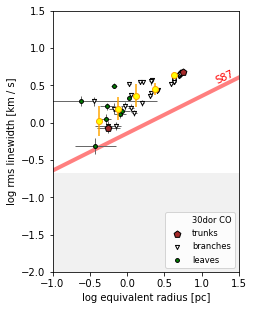

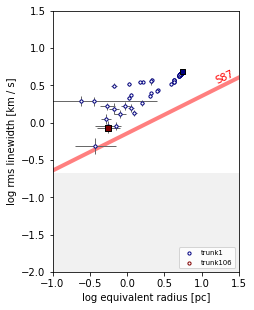

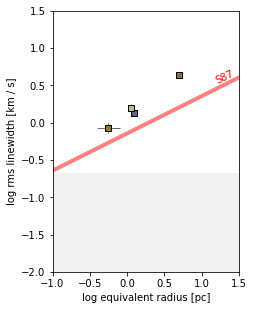

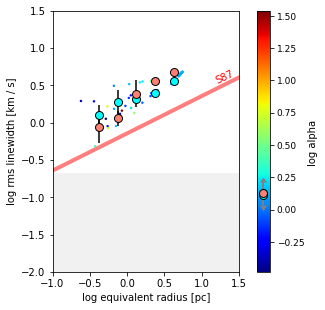

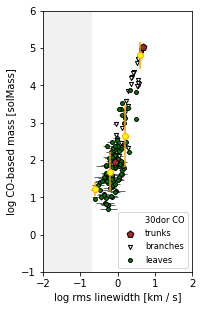

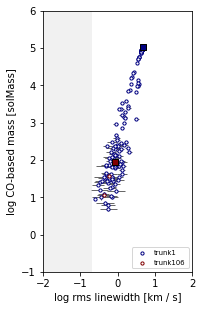

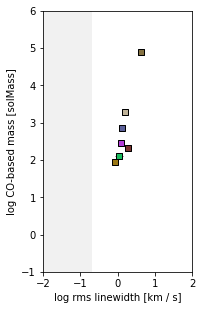

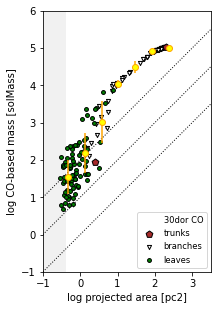

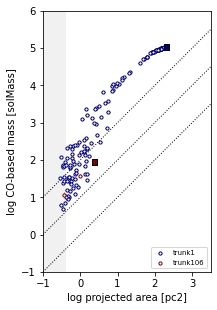

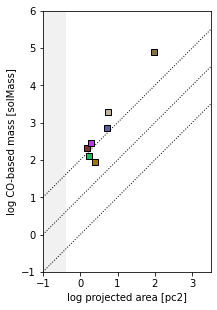

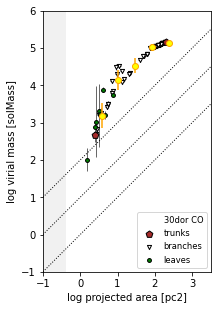

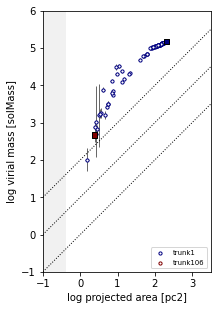

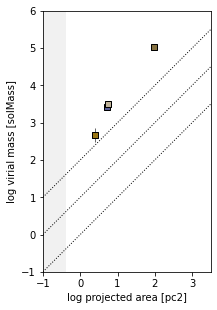

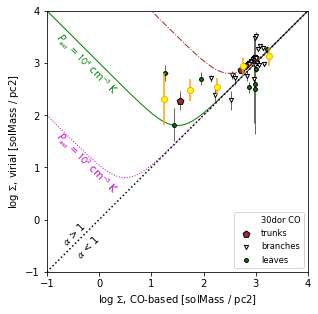

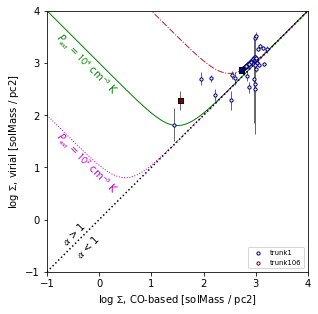

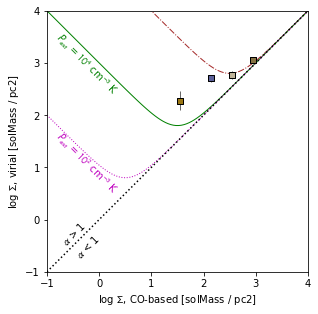

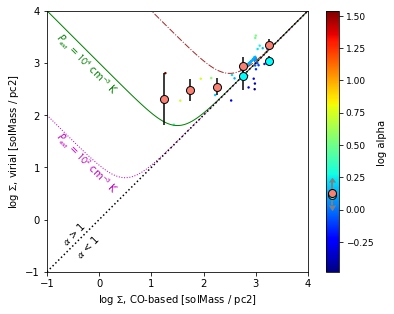

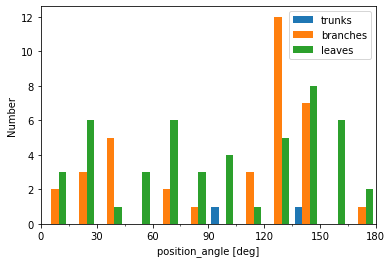

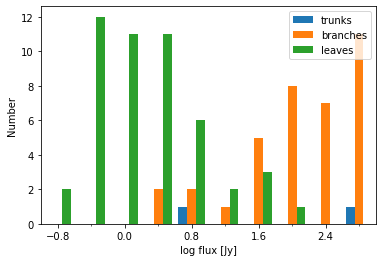

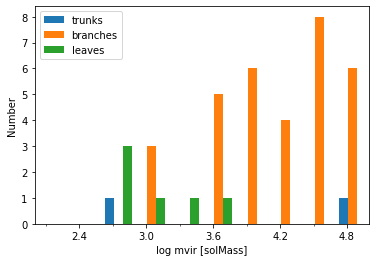

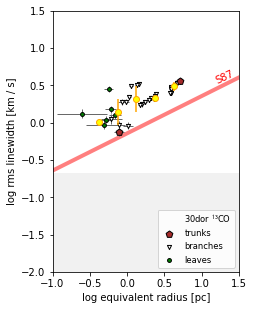

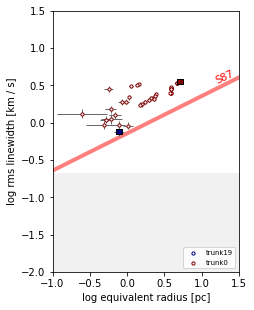

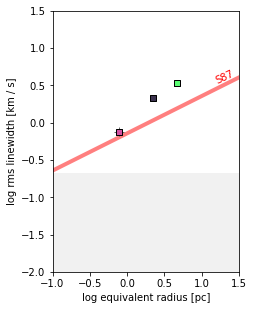

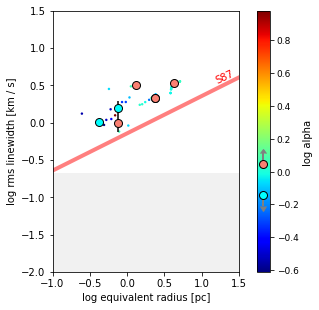

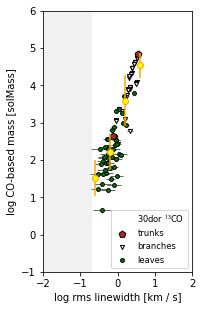

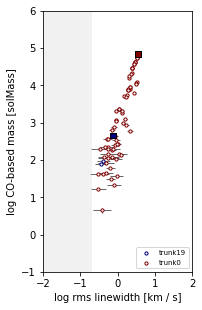

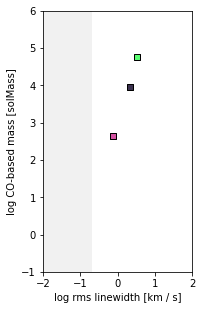

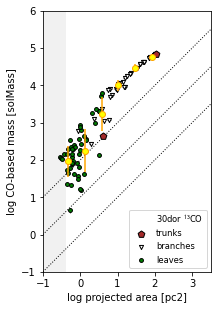

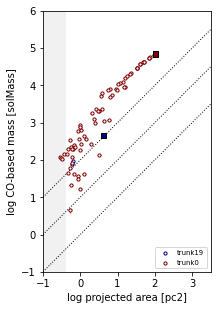

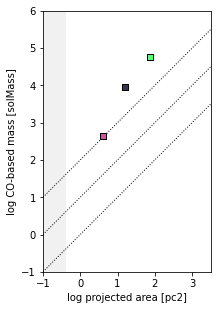

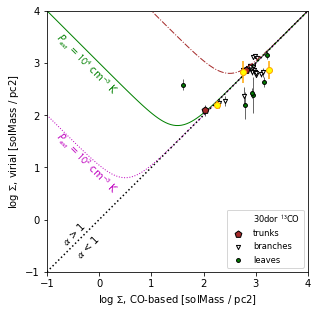

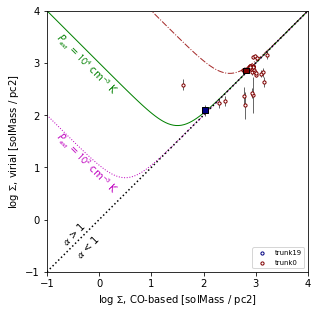

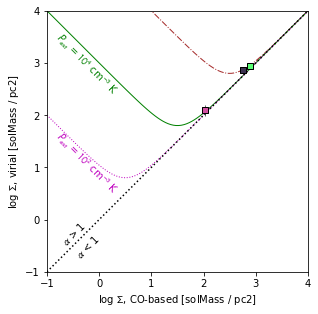

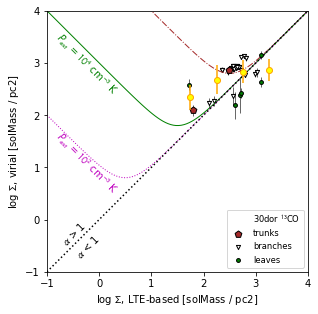

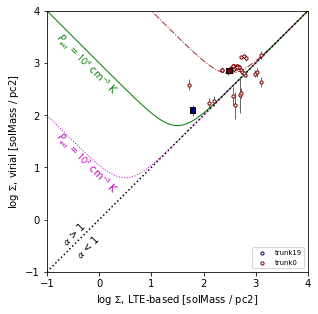

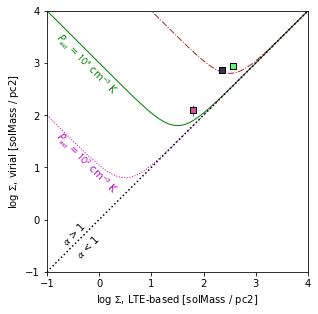

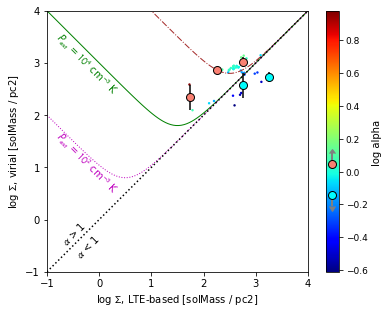

time: 6.09 s (started: 2022-07-10 12:02:33 -07:00)


In [7]:
old_dir = os.getcwd()
os.chdir(dendir)

for i, line in enumerate(['12', '13']):
    catalog = '30dor_'+line+'_full_catalog.txt'
    if line == '12':
        pltprops(catalog, dvkms=0.5, beam=2.5, 
            xplot=['rad_pc_dcon','vrms_k','area_pc2','area_pc2','siglum'],
            yplot=[     'vrms_k','mlumco',  'mlumco',    'mvir','sigvir'],
            xlims=[     [-1,1.5],  [-2,2],  [-1,3.5],  [-1,3.5],  [-1,4]],
            ylims=[     [-2,1.5],  [-1,6],    [-1,6],    [-1,6],  [-1,4]],
            pltname=[      'rdv','dvmlum','areamlum',  'areamv',   'bnd'],
            ccode=[         True,   False,     False,     False,    True], 
            colorcodes=['alpha'], nbin=10)
    else:
        pltprops(catalog, dvkms=0.5, beam=2.5, 
            xplot=['rad_pc_dcon','vrms_k','area_pc2',  'siglum','siglte'],
            yplot=[     'vrms_k','mlumco',  'mlumco',  'sigvir','sigvir'],
            xlims=[     [-1,1.5],  [-2,2],  [-1,3.5],    [-1,4],  [-1,4]],
            ylims=[     [-2,1.5],  [-1,6],    [-1,6],    [-1,4],  [-1,4]],
            pltname=[      'rdv','dvmlum','areamlum',     'bnd','bndlte'],
            ccode=[         True,   False,     False,     False,    True],
            colorcodes=['alpha'], nbin=10)

os.chdir(old_dir)